In [1]:
!pip install -q -U tensorflow-addons umap-learn

     |████████████████████████████████| 686kB 13.7MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 1.2MB 27.2MB/s 


In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

np.random.seed(2018)
np.random.RandomState(2018)
random.seed(2018)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
  
from skimage.filters import try_all_threshold, threshold_otsu

import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import umap

from tensorflow.keras.applications import VGG16, resnet, EfficientNetB0, EfficientNetB3, MobileNetV3Large, MobileNetV3Small, MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras import Model

import random
import tensorflow as tf
from tqdm.notebook import tqdm

from tensorflow.keras.datasets import mnist
 
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot

from IPython.display import SVG
from matplotlib import pyplot as plt
import math
import plotly.express as px
from sklearn.model_selection import train_test_split

np.random.seed(37)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
cr = range(1,56)
cn1 = [ "s" +str(x) for x in cr]
cn2 = [ "frg" +str(x) for x in cr]
class_names = cn1 + cn2

hold_out_1 = [ 2,  7,  8,  9, 15, 16, 18, 35, 41, 44, 48] 
hold_out_2 = [x+55 for x in hold_out_1]
hold_out = hold_out_1 + hold_out_2 
print(hold_out)
print(class_names)

[2, 7, 8, 9, 15, 16, 18, 35, 41, 44, 48, 57, 62, 63, 64, 70, 71, 73, 90, 96, 99, 103]
['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40', 's41', 's42', 's43', 's44', 's45', 's46', 's47', 's48', 's49', 's50', 's51', 's52', 's53', 's54', 's55', 'frg1', 'frg2', 'frg3', 'frg4', 'frg5', 'frg6', 'frg7', 'frg8', 'frg9', 'frg10', 'frg11', 'frg12', 'frg13', 'frg14', 'frg15', 'frg16', 'frg17', 'frg18', 'frg19', 'frg20', 'frg21', 'frg22', 'frg23', 'frg24', 'frg25', 'frg26', 'frg27', 'frg28', 'frg29', 'frg30', 'frg31', 'frg32', 'frg33', 'frg34', 'frg35', 'frg36', 'frg37', 'frg38', 'frg39', 'frg40', 'frg41', 'frg42', 'frg43', 'frg44', 'frg45', 'frg46', 'frg47', 'frg48', 'frg49', 'frg50', 'frg51', 'frg52', 'frg53', 'frg54', 'frg55']


In [4]:

def save_numpy(arr, file_path):
  with open(file_path, 'wb') as f:
    np.save(f, arr)

def load_numpy(file_path):  
  with open(file_path, 'rb') as f:
      return np.load(f) 

In [5]:
data_base_path = "drive/MyDrive/mlexperiments/data/cedar"
img_base_path = data_base_path
forg_list = os.listdir(data_base_path + "/full_forg")
orig_list = os.listdir(data_base_path + "/full_org")
forg_list.sort()
len(forg_list)
forg_list.remove("Thumbs.db")
orig_list.remove("Thumbs.db")
forg_list[:2], orig_list[:2]

(['forgeries_10_1.png', 'forgeries_10_10.png'],
 ['original_14_19.png', 'original_14_18.png'])

 ## Structuring as Classification Task

- Each original signer is an individual class. 55 signers each with 24 examples.
- Each forgery is an individual class. 55 forgeries, each with 24 examples.
- 110 example classes total

In [6]:
img_target_size = (224, 224)

def threshold_image(img_arr):
  thresh = threshold_otsu(img_arr)
  return np.where(img_arr > thresh, 255, 0)

def get_data_np(): 
  x_train = []
  y_train = []
  

  x_test = []
  y_test = []
  

  for i in tqdm(range(1,56)): 
    for j in range(1,25): 
      img_path = data_base_path + "/full_org/original_" + str(i) + "_" + str(j) + ".png" 
      img_np = load_img(img_path, target_size=img_target_size )
      img_np = np.squeeze(img_to_array(img_np))  
      img_np = threshold_image(img_np) 
      img_np = resnet.preprocess_input(img_np)
      
      if (i not in hold_out):
        x_train.append(img_np )
        y_train.append(i)
      else:
        x_test.append(img_np )
        y_test.append(i)

  for i in tqdm(range(1,56)): 
    for j in range(1,25): 
      img_path = data_base_path + "/full_forg/forgeries_" + str(i) + "_" + str(j) + ".png" 
      img_np = load_img(img_path, target_size=img_target_size )
      img_np = np.squeeze(img_to_array(img_np)) 
      img_np = threshold_image(img_np)
      img_np = resnet.preprocess_input(img_np) 

      if ((i+55) not in hold_out):
        x_train.append(img_np )
        y_train.append(i+55)
      else:
        x_test.append(img_np )
        y_test.append(i+55)

  return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

def generate_data():
  x_train, y_train, x_test, y_test = get_data_np()
  save_numpy(x_train, data_base_path+"/numpy/x_train.npy")
  save_numpy(y_train, data_base_path+"/numpy/y_train.npy")
  save_numpy(x_test, data_base_path+"/numpy/x_test.npy")
  save_numpy(y_test, data_base_path+"/numpy/y_test.npy")

def load_data():
  x_train = load_numpy(data_base_path+"/numpy/x_train.npy") 
  y_train = load_numpy(data_base_path+"/numpy/y_train.npy") 
  x_test = load_numpy(data_base_path+"/numpy/x_test.npy") 
  y_test = load_numpy(data_base_path+"/numpy/y_test.npy") 
  return x_train, y_train, x_test, y_test


def plot_features(test_features, y, title="UMAP Embedding Projection", metric="euclidean"): 
  print("Compute UMAP for vector with shape", test_features.shape, " metric:", metric)
  reducer = umap.UMAP(n_neighbors=15, n_components=2, metric=metric)
  embedding = reducer.fit_transform(test_features)

  colors = [ str(x) for x in y] 
  acm = [class_names[x] for x in y]

  fig = px.scatter(
      x=embedding[:, 0],
      y=embedding[:, 1],
      color=acm,
      opacity=0.5,
      hover_name=acm,
      symbol=acm,
      width=900,
      height=700,
      title=title,
  )
  fig.show()  

def plot_history(history, title=""): 
   
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Losss | ' + title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  
  plt.show()

In [41]:
y_train

array([  1,   1,   1, ..., 110, 110, 110])

In [8]:
x_train, y_train, x_test, y_test = load_data()

In [9]:
print(set(y_test))
print(set(hold_out))

{2, 7, 8, 9, 15, 16, 18, 35, 41, 44, 48, 57, 62, 63, 64, 70, 71, 73, 90, 96, 99, 103}
{2, 7, 8, 9, 15, 16, 18, 35, 41, 44, 48, 57, 62, 63, 64, 70, 71, 73, 90, 96, 99, 103}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


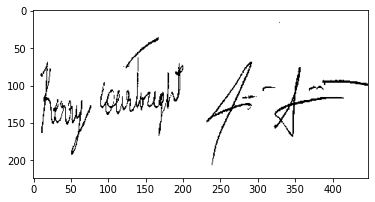

In [10]:
# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
plt.imshow(np.concatenate((x_train[-1],x_train[2]), axis=1));

In [11]:
input_shape =(224,224,3)
def get_resnet(input_shape):
  base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False
  )

  # base_cnn.trainable = False

  flatten = layers.Flatten()(base_cnn.output)
  dense1 = layers.Dense(512, activation="relu")(flatten)
  dense1 = layers.Dropout(0.2)(dense1)   #add dropout
  dense1 = layers.BatchNormalization()(dense1) 
  output = layers.Dense(256)(dense1)
  output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings

  embedding = Model(base_cnn.input, output, name="Embedding")

  trainable = False
  for layer in base_cnn.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable 
  return embedding   

input_shape =(224,224,3)

def create_base_conv_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    base_model = VGG16(
      weights="imagenet", input_shape=input_shape, include_top=False
    )

    base_cnn = Model( inputs=base_model.input, outputs=base_model.get_layer("block3_conv1").output)
    x = Conv2D(filters=64, kernel_size=3, name="conv3", padding='same')(base_cnn.output)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(filters=32, kernel_size=3,  name="conv4" , padding='same')(x)
    x = MaxPooling2D(pool_size=2)(x) 
    flatten = layers.Flatten()(x)
    # dense1 = layers.Dense(512, activation="relu")(flatten)
    # dense1 = layers.Dropout(0.2)(dense1)   #add dropout
    # dense1 = layers.BatchNormalization()(dense1) 
    output = layers.Dense(256)(flatten)
    output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings
    embedding = Model(base_cnn.input, output, name="Embedding")

    # base_model = VGG16(
    #   weights="imagenet", input_shape=input_shape, include_top=False
    # ) 
    # base_cnn = Model( inputs=base_model.input, outputs=base_model.get_layer("block3_conv1").output)
    # x = Conv2D(filters=64, kernel_size=3, name="conv3", padding='same')(base_cnn.output)
    # x = MaxPooling2D(pool_size=2)(x)
    # x = Conv2D(filters=32, kernel_size=3, name="conv3", padding='same')(base_cnn.output)
    # # x = layers.concatenate([x, base_cnn.output]) 
    # x = Conv2D(filters=32, kernel_size=3,  name="conv4" , padding='same')(x)
    # x = MaxPooling2D(pool_size=3)(x) 
    # flatten = layers.Flatten()(x)
    # # dense1 = layers.Dense(512, activation="relu")(flatten)
    # # dense1 = layers.Dropout(0.2)(dense1)   #add dropout
    # # dense1 = layers.BatchNormalization()(dense1) 
    # output = layers.Dense(256)(flatten)
    # output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings
    # embedding = Model(base_cnn.input, output, name="Embedding")
        
 
        
    return embedding

 

In [12]:
# Compile the model
# warning .. without setting batch size to something reasonable like 64, 
# training loss degrades to nan .. oops!

batch_size = 64
num_epochs = 30


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10,
    decay_rate=0.80,
    staircase=False)

triplet_model = create_base_conv_network(input_shape)
triplet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),  
    loss=tfa.losses.TripletSemiHardLoss())

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
# triplet_model.summary()

In [14]:
# Train the network
triplet_history = triplet_model.fit(
    x_train, y_train, 
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    epochs=num_epochs)

Epoch 1/30
33/33 [==============================] - 27s 193ms/step - loss: 0.9080 - val_loss: 0.7612
Epoch 2/30
33/33 [==============================] - 5s 156ms/step - loss: 0.7978 - val_loss: 0.7223
Epoch 3/30
33/33 [==============================] - 5s 156ms/step - loss: 0.7600 - val_loss: 0.7151
Epoch 4/30
33/33 [==============================] - 5s 155ms/step - loss: 0.7587 - val_loss: 0.7096
Epoch 5/30
33/33 [==============================] - 5s 156ms/step - loss: 0.7213 - val_loss: 0.7074
Epoch 6/30
33/33 [==============================] - 5s 155ms/step - loss: 0.7374 - val_loss: 0.7086
Epoch 7/30
33/33 [==============================] - 5s 155ms/step - loss: 0.6965 - val_loss: 0.7066
Epoch 8/30
33/33 [==============================] - 5s 155ms/step - loss: 0.6858 - val_loss: 0.7063
Epoch 9/30
33/33 [==============================] - 5s 155ms/step - loss: 0.7153 - val_loss: 0.7058
Epoch 10/30
33/33 [==============================] - 5s 156ms/step - loss: 0.7140 - val_loss: 0.705

In [15]:
!rm -rf models

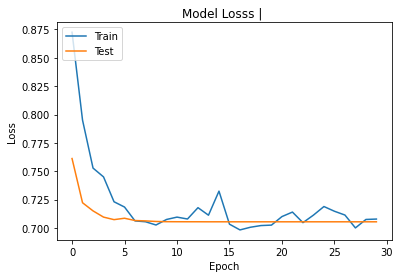

In [16]:
plot_history(triplet_history)

In [17]:
model_basepath = "drive/MyDrive/mlexperiments/siamese/"

def save_model(name, model):
  print(">>> Saving model", name) 
  model.save("models/" + name)  
  !gsutil -m cp -r models $model_basepath 
 
save_model("cedar_triplet", triplet_model) 

>>> Saving model cedar_triplet
INFO:tensorflow:Assets written to: models/cedar_triplet/assets
Copying file://models/cedar_triplet/saved_model.pb...
Copying file://models/cedar_triplet/variables/variables.index...
Copying file://models/cedar_triplet/variables/variables.data-00000-of-00001...
\
Operation completed over 3 objects/26.9 MiB.                                     


In [18]:
!gsutil -m cp -r models $model_basepath 


Copying file://models/cedar_triplet/saved_model.pb...
Copying file://models/cedar_triplet/variables/variables.data-00000-of-00001...
Copying file://models/cedar_triplet/variables/variables.index...
/ [3/3 files][ 26.9 MiB/ 26.9 MiB] 100% Done                                    
Operation completed over 3 objects/26.9 MiB.                                     


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
base_model = resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False
  )
resnet_model = Model(
    inputs=base_model.input, outputs=base_model.get_layer("conv5_block3_out").output
)

94773248/94765736 [==============================] - 1s 0us/step


In [36]:
test_features = resnet_model.predict(x_test, batch_size=128)
test_features = np.reshape(test_features, (test_features.shape[0],-1))
plot_features(test_features, y_test, title="UMAP Embedding Projection  Triplet Base ResNet" , metric="cosine" )

Compute UMAP for vector with shape (528, 100352)  metric: cosine


In [22]:
test_features = triplet_model.predict(x_test, batch_size=128)
plot_features(test_features, y_test, title="UMAP Embedding Projection  Triplet" , metric="cosine" )

Compute UMAP for vector with shape (528, 256)  metric: cosine


In [38]:
test_features = triplet_model.predict(x_train, batch_size=128)
plot_features(test_features, y_train, title="UMAP Embedding Projection  Triplet" , metric="cosine" )

Compute UMAP for vector with shape (2112, 256)  metric: cosine


IndexError: ignored

In [23]:
import json
triplet_model.save_weights('triplet_weights', save_format="tf")
triplet_json_string = triplet_model.to_json()
with open('triplet_json', 'w') as f:
  json.dump(triplet_json_string, f, ensure_ascii=False)

In [24]:
import tarfile

tar = tarfile.open("model.tar.gz", "w:gz")
tar.add("triplet_weights.data-00000-of-00001", arcname="KerasModel")
tar.close()

In [25]:
!ls -lh 

total 52M
-rw-r--r-- 1 root root   87 May 24 17:12 checkpoint
drwx------ 5 root root 4.0K May 24 17:07 drive
drwxr-xr-x 3 root root 4.0K May 24 17:11 models
-rw-r--r-- 1 root root  25M May 24 17:12 model.tar.gz
drwxr-xr-x 1 root root 4.0K May  6 13:44 sample_data
-rw-r--r-- 1 root root 7.9K May 24 17:12 triplet_json
-rw-r--r-- 1 root root  27M May 24 17:12 triplet_weights.data-00000-of-00001
-rw-r--r-- 1 root root 3.7K May 24 17:12 triplet_weights.index


In [26]:
!rm triplet_json

In [27]:
import tensorflow
cedar_model =  tensorflow.keras.models.load_model(model_basepath +'models/cedar_triplet')


In [28]:
import tensorflow
import tensorflow as tf
from keras.models import load_model

In [29]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-b0.tgz 
!tar -xf efficientnetv2-b0.tgz

--2021-05-24 17:12:52--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/efficientnetv2-b0.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105641003 (101M) [application/octet-stream]
Saving to: ‘efficientnetv2-b0.tgz’

efficientnetv2-b0.t 100%[===================>] 100.75M  33.0MB/s    in 3.1s    

2021-05-24 17:12:56 (33.0 MB/s) - ‘efficientnetv2-b0.tgz’ saved [105641003/105641003]



In [30]:
 
base_model = VGG16(
    weights="imagenet", input_shape=input_shape, include_top=False
  )


In [31]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [32]:
base_cnn = Model(
    inputs=base_model.input, outputs=base_model.get_layer("block3_conv1").output
)
x = Conv2D(filters=64, kernel_size=3, name="conv3", padding='same')(base_cnn.output)
x = Conv2D(filters=64, kernel_size=3, name="conv35", padding='same')(x) 

skip_layer = layers.concatenate([x, base_cnn.output])

x = Conv2D(filters=32, kernel_size=3,  name="conv4" , padding='same')(skip_layer)
x = MaxPooling2D(pool_size=3)(x) 
# x = Conv2D(filters=32, kernel_size=3,  name="conv45" , padding='same')(x)
# x = MaxPooling2D(pool_size=2)(x) 
flatten = layers.Flatten()(x)  
output = layers.Dense(256, activation="relu")(flatten)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings
embedding = Model(base_cnn.input, output, name="Embedding")

In [33]:
base_model = VGG16(
      weights="imagenet", input_shape=input_shape, include_top=False
    )

base_cnn = Model( inputs=base_model.input, outputs=base_model.get_layer("block3_conv1").output)
x = Conv2D(filters=64, kernel_size=3, name="conv3", padding='same')(base_cnn.output)
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=32, kernel_size=3, name="conv3", padding='same')(base_cnn.output)
x = layers.concatenate([x, base_cnn.output]) 
x = Conv2D(filters=32, kernel_size=3,  name="conv4" , padding='same')(x)
x = MaxPooling2D(pool_size=3)(x) 
flatten = layers.Flatten()(x)
# dense1 = layers.Dense(512, activation="relu")(flatten)
# dense1 = layers.Dropout(0.2)(dense1)   #add dropout
# dense1 = layers.BatchNormalization()(dense1) 
output = layers.Dense(256)(flatten)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output) # L2 normalize embeddings
embedding = Model(base_cnn.input, output, name="Embedding")
    
 

In [34]:
embedding.summary()

Model: "Embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________

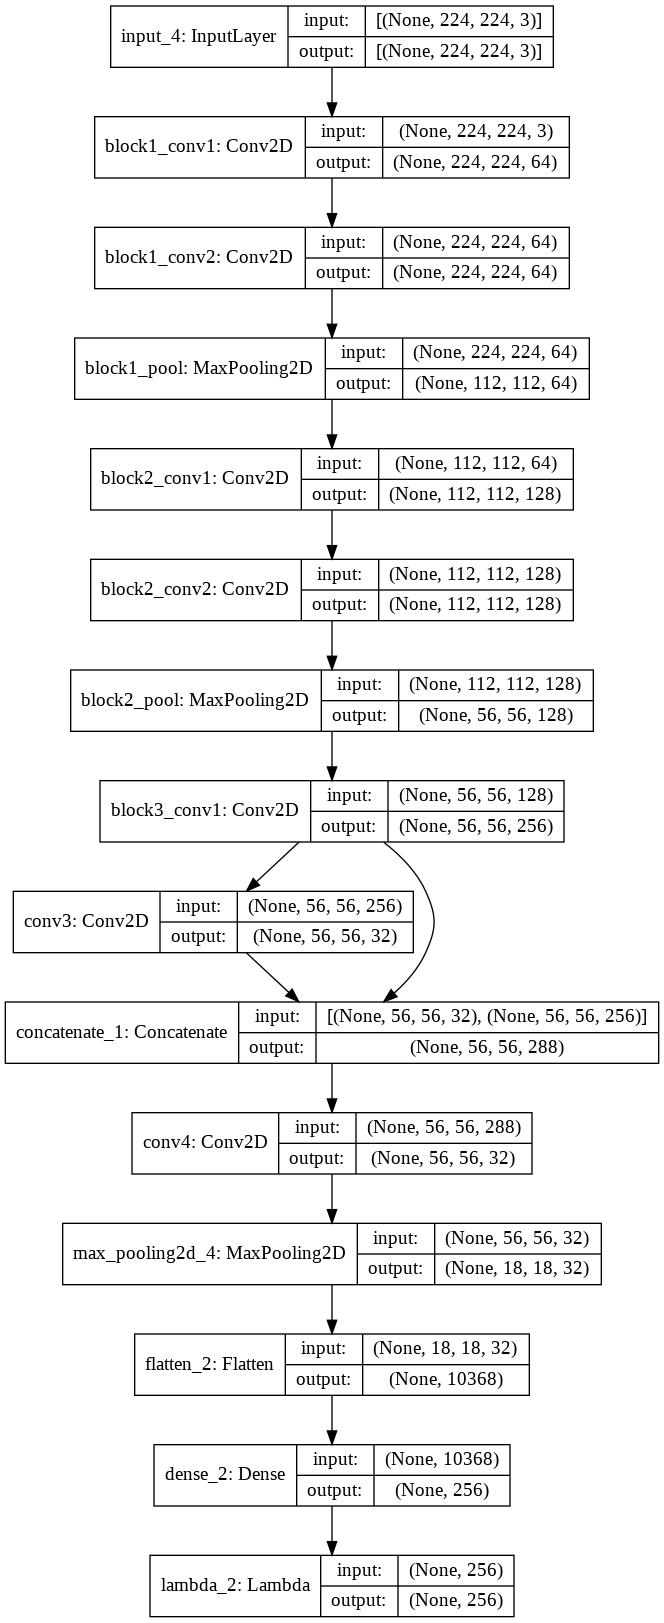

In [35]:
tf.keras.utils.plot_model(embedding, "mini_resnet.png", show_shapes=True)